100%|██████████████████████████████████████████████████████████████████████████████| 5489/5489 [03:36<00:00, 25.39it/s]



Training Isolation Forest...

Training One-Class SVM...

Training Local Outlier Factor...

Training Elliptic Envelope...


C:\Users\ruzha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\covariance\_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-161.607823257153910 > -162.386792768811461). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
C:\Users\ruzha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\covariance\_robust_covariance.py:187: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-161.587975594811780 > -162.382819447789956). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
C:\Users\ruzha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\skl


Training PCA...
--- Isolation Forest ---
Accuracy: 0.9914
Classification Report:
              precision    recall  f1-score    support
0              0.994552  0.996764  0.995657  4945.0000
1              0.636364  0.509091  0.565657    55.0000
accuracy       0.991400  0.991400  0.991400     0.9914
macro avg      0.815458  0.752928  0.780657  5000.0000
weighted avg   0.990612  0.991400  0.990927  5000.0000
Confusion Matrix:
[[4929   16]
 [  27   28]]


--- One-Class SVM ---
Accuracy: 0.983
Classification Report:
              precision    recall  f1-score   support
0              0.991306  0.991507  0.991406  4945.000
1              0.222222  0.218182  0.220183    55.000
accuracy       0.983000  0.983000  0.983000     0.983
macro avg      0.606764  0.604844  0.605795  5000.000
weighted avg   0.982846  0.983000  0.982923  5000.000
Confusion Matrix:
[[4903   42]
 [  43   12]]


--- Local Outlier Factor ---
Accuracy: 0.981
Classification Report:
              precision    recall  f1-sco

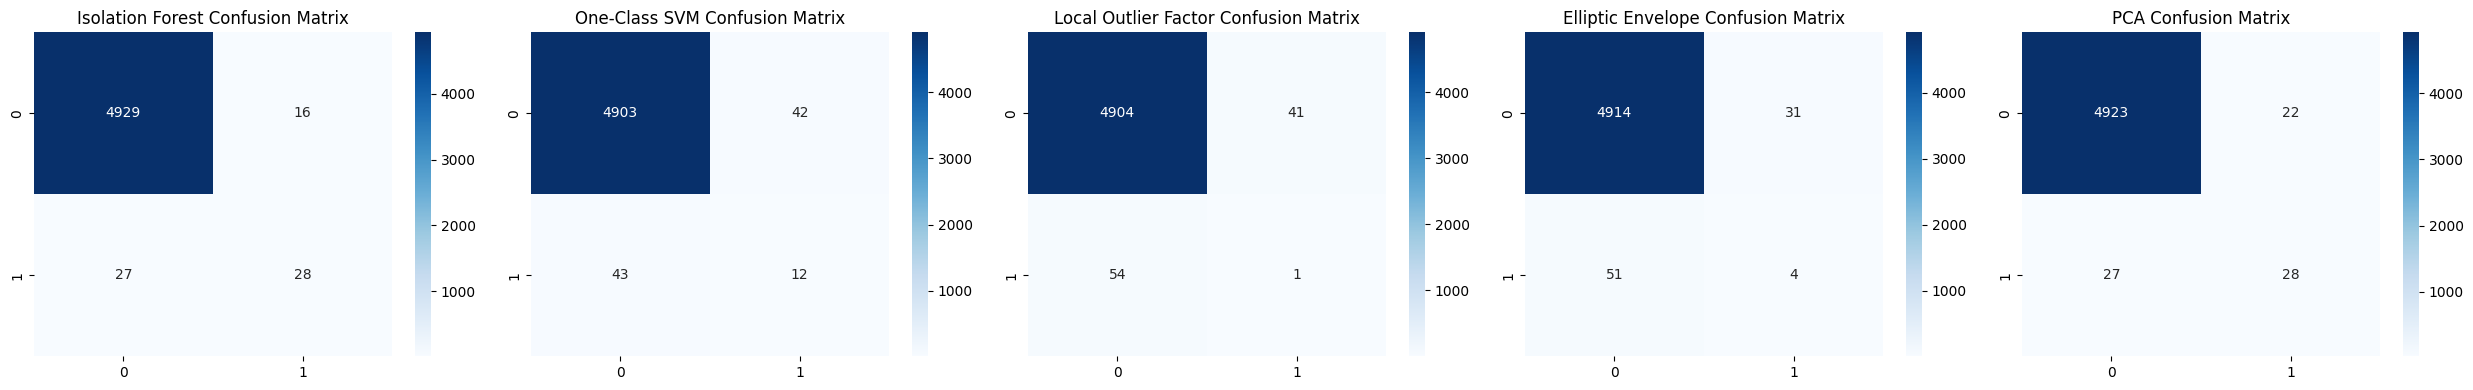

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

BASE_DIR = "X:/DataSet/Data"
AGG_LEVELS = ["agg_10_minutes", "agg_1_hour", "agg_1_day"]
FOLDERS = ["institutions", "institution_subnets", "ip_addresses_full", "ip_addresses_sample"]

selected_features = [
    "n_flows", "n_packets", "n_bytes", "avg_duration", "tcp_udp_ratio_packets",
    "tcp_udp_ratio_bytes", "dir_ratio_packets", "dir_ratio_bytes",
    "avg_ttl", "n_dest_ports", "n_dest_ip"
]

all_files = []
for folder in FOLDERS:
    for agg in AGG_LEVELS:
        dir_path = os.path.join(BASE_DIR, folder, agg)
        if os.path.exists(dir_path):
            all_files.extend(
                [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith(".csv")]
            )

# Load subset of ~50,000 files
subset_files = all_files[:50000]

# Load and filter
df_list = []
for f in tqdm(subset_files):
    try:
        df = pd.read_csv(f)
        if all(feat in df.columns for feat in selected_features):
            df_list.append(df[selected_features])
    except:
        continue

full_df = pd.concat(df_list, ignore_index=True).dropna()

# Label: simulate anomalies based on high flow count
full_df['anomaly'] = (full_df['n_flows'] > full_df['n_flows'].quantile(0.99)).astype(int)

X = full_df[selected_features]
y = full_df['anomaly']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=5000, train_size=45000, random_state=42)

models = {
    'Isolation Forest': IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1),
    'One-Class SVM': OneClassSVM(nu=0.01, kernel='rbf', gamma='scale'),
    'Local Outlier Factor': LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=True),
    'Elliptic Envelope': EllipticEnvelope(contamination=0.01, random_state=42),
    'PCA': PCA(n_components=2)  # PCA used for anomaly detection by reconstruction error
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name == 'PCA':
        model.fit(X_train)
        X_proj = model.inverse_transform(model.transform(X_test))
        errors = np.mean(np.abs(X_proj - X_test), axis=1)
        y_pred = (errors > np.percentile(errors, 99)).astype(int)
    else:
        model.fit(X_train)
        y_pred = model.predict(X_test)
        y_pred = np.where(y_pred == -1, 1, 0)

    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'accuracy': acc,
        'report': report,
        'confusion': cm
    }

# Show results
for name, res in results.items():
    print(f"--- {name} ---")
    print("Accuracy:", res['accuracy'])
    print("Classification Report:")
    print(pd.DataFrame(res['report']).transpose())
    print("Confusion Matrix:")
    print(res['confusion'])
    print("\n")

# Plot confusion matrices
fig, axs = plt.subplots(1, len(results), figsize=(5 * len(results), 4))
for ax, (name, res) in zip(axs, results.items()):
    sns.heatmap(res['confusion'], annot=True, fmt='d', ax=ax, cmap="Blues")
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()
